<a href="https://colab.research.google.com/github/jpbm2w/cmpsc4540/blob/main/Long_Short_Term_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Long Short-Term Memory Networks
These networks, commonly called LSTMs, see most of their success in Natural Language Processing and Signal Processing due to the recurrent nature.

There are a couple things to pay attention to when designing a network:
1. Make sure your Tensor shapes are correct
2. Make sure your computer can handle the amount of weights. Each unrolled layer has it's own weights and it can get large very quickly
3. Note there is no activation (this is because of the LSTM Unit itself). For more information check out the WhatAre LSTMs notebook

The network built below is just a single LSTM layer feeding into a linear layer to ensure we always have the same output size.

In [13]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, in_size: int = 1,
                 h_size: int = 50,
                 out_size: int = 1,
                 num_layers: int = 1,
                 batch_first: bool = True,
                 dropout: float = 0.0) -> None:
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=in_size,
                           hidden_size=h_size,
                           num_layers=num_layers,
                           batch_first=batch_first,
                           dropout=dropout)
        self.lin = nn.Linear(h_size, out_size)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)  # RNN variants expect (N, L, H)
        x, (_, _) = self.rnn(x)  # Returns (N, L, hidden_size)
        out = self.lin(x[:, -1, :])  # Feeds hidden stats of last cell to FCN

        return out

## Data Generation

Here we start to generate data.

#### Building the Dataset

This is when we finally build the dataset. Notice how in building this we generate a signal of x2 the number of samples. This is so that we have a continuous signal where the first half can be considered input data and the second half is the corresponding sine wave.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

filepaths = [
    '/content/drive/My Drive/Project3_LFP_data/Part1SubjectHB10.h5',
    '/content/drive/My Drive/Project3_LFP_data/Part2SubjectHB13.h5',
    '/content/drive/My Drive/Project3_LFP_data/Rat08-20130711_017.h5'
]

fs = [h5py.File(filename, 'r') for filename in filepaths]
fss = [f.attrs['fs'][0] for f in fs]

print("Sampling rates are:\n")
for i in range(len(filepaths)):
    print(str(filepaths[i]) + ": " + str(fss[i]))

sampling_rates = {
    'Part1SubjectHB10.h5': fss[0],
    'Part2SubjectHB13.h5': fss[1],
    'Rat08-20130711_017.h5': fss[2],
}

Sampling rates are:

/content/drive/My Drive/Project3_LFP_data/Part1SubjectHB10.h5: 1000.0
/content/drive/My Drive/Project3_LFP_data/Part2SubjectHB13.h5: 1000.0
/content/drive/My Drive/Project3_LFP_data/Rat08-20130711_017.h5: 1250.0


In [15]:
filestates = []
for i in range(3):
  states = []
  print("File" + str(filepaths[i]))
  curFile = fs[i]
  for name, grp in curFile.items():
    states.append(name)
    print("State: %s" % (name))
    print("Segment IDs:")
    print(list(grp.keys()))
  filestates.append(states)
  print("\n")

File/content/drive/My Drive/Project3_LFP_data/Part1SubjectHB10.h5
State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '4', '5', '6', '7', '8', '9']


File/content/drive/My Drive/Project3_LFP_data/Part2SubjectHB13.h5
State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9']


File/content/drive/My Drive/Project3_LFP_data/Rat08-20130711_017.h5
State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '2

In [16]:
lfps = []
for j in range(3):
  lfp = {key: [] for key in states}
  for key in filestates[j]:
    group = fs[j][key]
    n = len(group)
    for i in range(n):
      lfp[key].append(group[str(i+1)][()].astype(float))
  lfps.append(lfp)
  print(lfp)

{'NREM': [array([-1129., -1152., -1170., ...,  2631.,  2593.,  2663.]), array([-492., -522., -298., ...,  -34.,  -81.,  -45.]), array([ -496.,  -431.,  -425., ..., -3005., -3175., -3350.]), array([ 395.,  353.,  349., ..., 1111.,  938.,  834.]), array([ 2233.,  2374.,  2504., ..., -1358., -1347., -1429.]), array([-930., -824., -797., ...,  508.,  419.,  231.]), array([1235., 1510., 1606., ...,  652.,  556.,  364.]), array([   79.,   256.,   267., ..., -2565., -2319., -2090.]), array([  -3., -122., -144., ..., -206., -327., -598.]), array([-1746., -1769., -1793., ...,   798.,   970.,  1058.]), array([ 726.,  692.,  542., ..., 2513., 2549., 2471.]), array([ -114.,  -138.,   -91., ..., -2226., -2608., -2942.]), array([ -216.,  -100.,   -58., ..., -2707., -3131., -3538.]), array([ 879.,  850.,  759., ..., 1246., 1362., 1409.]), array([ 148.,  167.,  159., ..., 1166., 1108., 1008.]), array([ -205.,  -243.,  -279., ..., -1241., -1018.,  -838.]), array([ 2907.,  2830.,  2655., ..., -1777., -1

In [17]:
clip_length_sec = 5
subject_clips_labels = {}

for j, filepath in enumerate(filepaths):
    file_data = lfps[j]
    sampling_rate = fss[j]
    num_samples_per_clip = int(sampling_rate * clip_length_sec)

    subject_clips = []
    subject_labels = []

    for state, segments in file_data.items():
        label = 0 if state == 'NREM' else 1
        for segment in segments:
            num_clips = len(segment) // num_samples_per_clip
            for i in range(num_clips):
                start = i * num_samples_per_clip
                end = start + num_samples_per_clip
                subject_clips.append(segment[start:end])
                subject_labels.append(label)

    subject_clips = np.array(subject_clips)
    subject_labels = np.array(subject_labels)

    subject_identifier = filepath.split('/')[-1]
    subject_clips_labels[subject_identifier] = (subject_clips, subject_labels)
print(subject_clips)
print(subject_labels)

[[  -73.   -52.  -112. ...  1049.  1135.  1046.]
 [  996.   985.   963. ...   540.   539.   616.]
 [  642.   570.   588. ...  -117.   -77.  -101.]
 ...
 [  193.   148.   277. ...   974.  1051.  1019.]
 [  962.   900.   780. ...   710.   791.   774.]
 [  764.   859.   930. ... -4418. -4366. -4357.]]
[0 0 0 ... 1 1 1]


#### DataLoaders

DataLoaders are a feature of PyTorch meant to make training easier. Below we just simply split the data to be a 75% training 25% validation split and pass them to the DataLoader with the batch size and whether or not to shuffle the data. Now we are ready to look at training.

In [18]:
import torch
import numpy as np

common_length = 5000
all_segments = []
all_labels = []

for subject_identifier, (clips, labels) in subject_clips_labels.items():
    for i, segment in enumerate(clips):
        if len(segment) >= common_length:
            all_segments.append(segment[:common_length])
            all_labels.append(labels[i])

data = torch.stack([torch.from_numpy(segment) for segment in all_segments], dim=0).unsqueeze(1)

labels = torch.tensor(all_labels, dtype=torch.float32)

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
split_idx = int(0.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

data = data.float()
labels = labels.float()

train_data = DataLoader(TensorDataset(data[:split_idx], labels[:split_idx]), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(data[split_idx:], labels[split_idx:]), batch_size=batch_size, shuffle=False)

x_sample, y_sample = next(iter(train_data))
print("Sample input type:", x_sample.dtype)
print("Sample label type:", y_sample.dtype)

4126
torch.Size([5502, 1, 5000])
torch.Size([5502])
Sample input type: torch.float32
Sample label type: torch.float32


#### Training

This is an example of a training loop. Notice it takes both validation and training into account. While this is not necessary, we do it just so we can run both in parallel and maximize our efficiency.

The key lines here are:
```python
loss.backward()
optimizer.step()
```
and this is what allows for training. If you notice, these are only called when using a training dataset because these two lines are the actual backpropagation and updates of the weights in the network. If these lines are not called the network does not learn. The rest is basically built around trying to help the net learn easier (updatable learning rates, loss printing, tqdm, etc.)

*If you want to change the loss function* take a look at the line that says:
```python
loss_func = nn.MSELoss() if 'loss_function' not in kwargs else kwargs.get('loss_function')
```
This basically means we can specify a loss function to the fit function call, or if you want simply change the function from Mean Squared Error here.

In [24]:
from typing import Optional, Tuple, List
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn as nn

def fit(model: nn.Module,
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int = 50,
        device: str = 'cpu',
        write_losses: bool = False,
        save_filepath: Optional[str] = None,
        **kwargs) -> Tuple[List, List]:
    """
    Function used to fit the specified model with the provided data
    :param model: neural network pytorch model
    :param training_loader: pytorch dataloader containing the training data
    :param validation_loader: pytorch dataloader containing the validation data
    :param epochs: number of epochs to train
    :param device: which device to train the model on. Should be either "cuda:0" or "cpu"
    :param write_losses: boolean flag as to report losses during training
    :param save_filepath: path to save model, if not specified, no model is saved
    :param kwargs: "optim" optimizer,
                    "loss_function" loss function,
                    "decay_rate" decay rate,
                    "model_save_path" model save path,
                    "loss_save_path" csv save path
    :return: training and validation losses over each epoch
    """
    train_loss_list = []
    val_loss_list = []

    # splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) if 'optim' not in kwargs else kwargs.get('optim')

    loss_func = nn.BCEWithLogitsLoss()

    decay_rate = .99995 if 'decay_rate' not in kwargs else kwargs.get('decay_rate')
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    temp_loss = 100000000000000.0

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))

                # backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # calculating total loss
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch % 10 == 0 and write_losses:
            tqdm.write('{} train loss: {.6f} val loss: {.6f}'.format(epoch + 1, train_loss, val_loss))

        # saving best model
        if train_loss < temp_loss and save_filepath:
            torch.save(model, save_filepath)
            temp_loss = train_loss

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


    return train_loss_list, val_loss_list

In [ ]:
import copy

epochs = 20
model = LSTM()
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device)

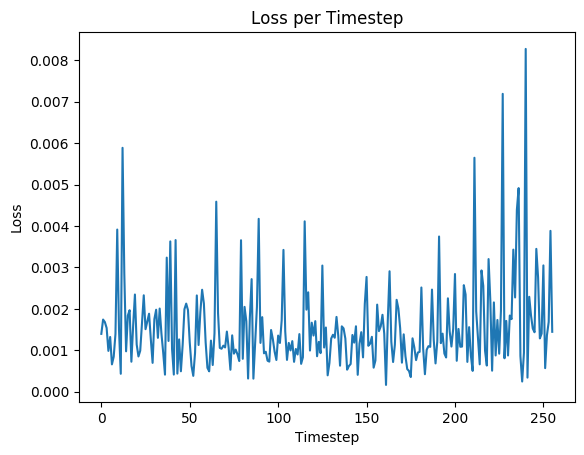

In [ ]:
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[List[float], List[float]]:
    losses = {i:0 for i in range(0, labels.shape[2], 1)}
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)
        output = output.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        for t in range(0, labels.shape[2], 1):
            y_true = y[:,:,t]
            y_pred = output[:,t]
            squared_error = ((y_true - y_pred) ** 2)
            # print(squared_error.shape)
            losses[t] += np.sum(squared_error)
    #  TODO Losses normalized by std of each timestep
    return losses


losses = validate_model(model, valid_data, device)

lists = sorted(losses.items())
timestep, loss_val = zip(*lists)
plt.plot(timestep, loss_val)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.title('Loss per Timestep')

plt.show()

In [ ]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 256)
(32, 1, 256)
(32, 256)


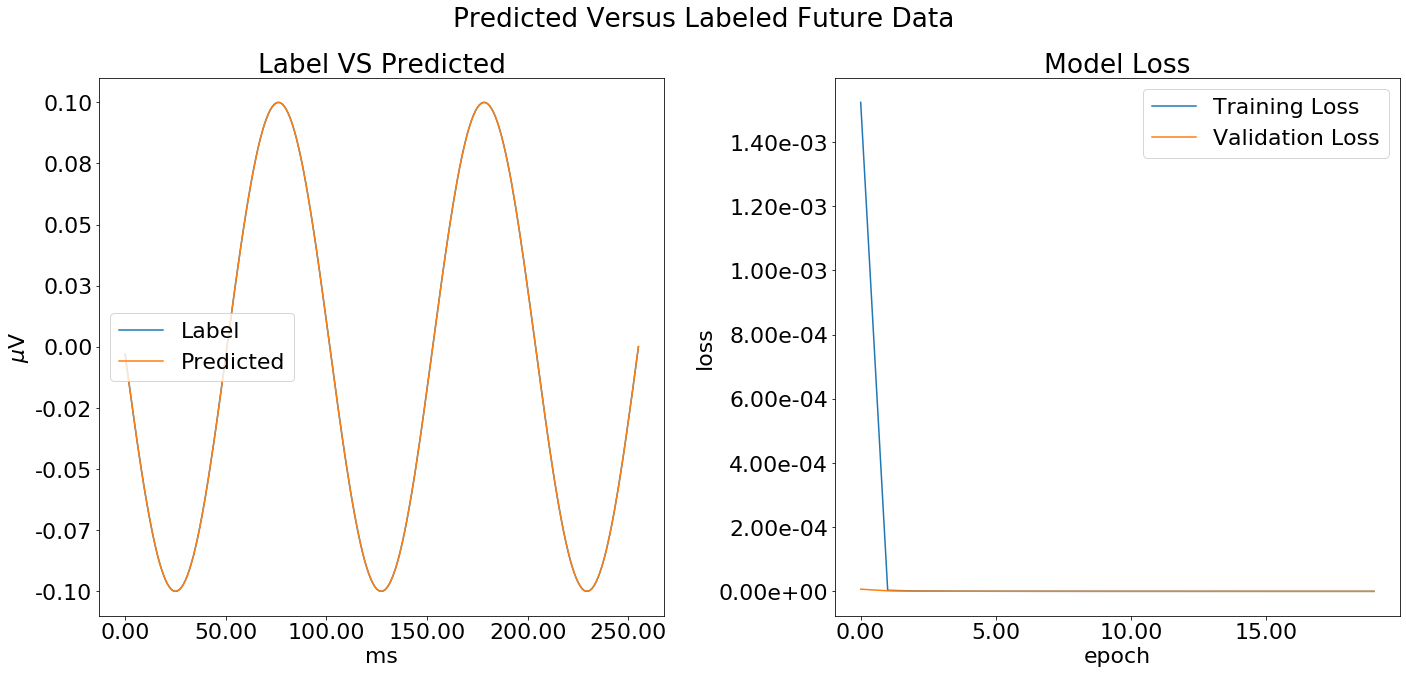

In [ ]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Predicted Versus Labeled Future Data')

t = np.arange(0, samples)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,:], label='Predicted')
ax1.set_xlabel('ms')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Recurrent Neural Networks (RNNs) are designed to handle sequential data, making them ideal for tasks where context from previous inputs is crucial, such as language processing or time-series analysis. At the core of an RNN is its ability to maintain an internal state or memory by incorporating outputs from previous time steps into the current step’s computation. This looping mechanism allows RNNs to understand temporal dynamics and patterns within data. However, standard RNNs often struggle with long sequences due to issues like vanishing or exploding gradients. To address this, variants like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Units) networks introduce gates that regulate information flow, improving the network’s ability to capture long-range dependencies in data. These enhancements make RNNs particularly effective for analyzing complex sequential data, such as the Local Field Potential (LFP) signals from rats, where understanding the temporal sequence is key to predicting states like sleep or wakefulness accurately.